In [1]:
import numpy as np
import math
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from two_stage_player import *
from dfo_player import *
from solo_player import *
from online_player import *

from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 3

In [2]:
np.random.seed(0)

d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_0 = 1
epsilon_1 = 1  # Epsilon sensitivity parameters
epsilon_2 = 1

Sigma_x_p1 = np.eye(d_1)  # Covariance of x^k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.1  # Variance of y^k
sigma_y_p2 = 0.1

beta_p1 = sample_sphere(1,d_1)
beta_p2 = sample_sphere(1,d_2)

# s_1 = sample_sphere(epsilon_1,d_1+d_2)  # Performativity parameters
# mu_p1 = s_1[0:d_1]
# gamma_p1 = s_1[d_1:]
# s_2 = sample_sphere(epsilon_2,d_1+d_2)
# mu_p2 = s_2[0:d_2]
# gamma_p2 = s_2[d_2:]

mu_p1 = sample_sphere(epsilon_0,d_1)
gamma_p1 = sample_sphere(epsilon_1,d_2)
mu_p2 = sample_sphere(epsilon_0,d_2)
gamma_p2 = sample_sphere(epsilon_2,d_1)

p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

N1 = 1
N2 = 5

num_rounds_lst = np.logspace(1.7,5,N2,dtype='int')
# num_rounds_lst = [50, 100, 500, 1000, 5000, 10000, 50000, 100000]
num_alternate_rounds = 100
num_test = 100

In [3]:
p1_risks = np.zeros((N1,N2))
p2_risks = np.zeros((N1,N2))
theta_final_p1 = np.zeros((N1,N2,d_1))
theta_final_p2 = np.zeros((N1,N2,d_2))

delta = 1e-0
eta = 1e-1
num_rounds = num_rounds_lst[-1]

for j in trange(N1):
    player_one = DFOPlayer(delta,eta)
    player_two = DFOPlayer(delta,eta)
    game_dfo = DecisionDependentGame(player_one, player_two,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func)
    for i in range(num_rounds+1):
        game_dfo.theta_p1 = player_one.perturb_theta()
        game_dfo.theta_p2 = player_two.perturb_theta()

        PR_1_oracle, PR_2_oracle = game_dfo.evaluate_closed_perf_risk()

        game_dfo.theta_p1 = player_one.update_theta(PR_1_oracle)
        game_dfo.theta_p2 = player_two.update_theta(PR_2_oracle)

        if i in num_rounds_lst:
            p1_risks[j,np.where(num_rounds_lst==i)] = PR_1_oracle
            p2_risks[j,np.where(num_rounds_lst==i)] = PR_2_oracle

            theta_final_p1[j,np.where(num_rounds_lst==i)] = game_dfo.theta_p1
            theta_final_p2[j,np.where(num_rounds_lst==i)] = game_dfo.theta_p2

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.81s/it]


In [4]:
p3_risks = np.zeros((N1,N2))
p4_risks = np.zeros((N1,N2))
theta_final_p3 = np.zeros((N1,N2,d_1))
theta_final_p4 = np.zeros((N1,N2,d_2))

for i in trange(N1):
    for num_rounds in num_rounds_lst:
        player_three = TwoStagePlayer()
        player_four = TwoStagePlayer()
        game = DecisionDependentGame(player_three, player_four,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func,
                                     num_rounds, num_alternate_rounds, num_test)

        game.run_train()
        game.run_post_train_alternating()

        PR3, PR4 = game.evaluate_closed_perf_risk()
        p3_risks[i,np.where(num_rounds_lst==num_rounds)] = PR3
        p4_risks[i,np.where(num_rounds_lst==num_rounds)] = PR4

        theta_final_p3[i,np.where(num_rounds_lst==num_rounds)] = game.theta_p1
        theta_final_p4[i,np.where(num_rounds_lst==num_rounds)] = game.theta_p2

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.89s/it]


In [5]:
# p5_risks = np.zeros((N1,N2))
# p6_risks = np.zeros((N1,N2))
# theta_final_p5 = np.zeros((N1,N2,d_1))
# theta_final_p6 = np.zeros((N1,N2,d_2))

# nu = 1e-3
# eta = 1e-2
# n = 100
# B = 1
# R = 1e6
# num_rounds = num_rounds_lst[-1]

# for k in trange(N1):
#     player_five = OnlinePlayer(d_1, d_1+d_2, d_1, eta, nu, n, B, R)
#     player_six = OnlinePlayer(d_2, d_1+d_2, d_2, eta, nu, n, B, R)
#     game_online = DecisionDependentGame(player_five, player_six,
#                                         p1_data_params, p2_data_params,
#                                         p1_data_generating_func, p2_data_generating_func,
#                                         num_test = 1000)
#     l=0
#     for i in range(math.ceil(num_rounds/(n))+1):
#         theta_5, u_5k = player_five.perturb_theta()
#         theta_6, u_6k = player_six.perturb_theta()
#         x_5k = []
#         y_5k = []
#         x_6k = []
#         y_6k = []
#         for j in range(n):
#             game_online.theta_p1 = theta_5+(u_5k[:,j]).reshape((-1,1))
#             game_online.theta_p2 = theta_5+(u_6k[:,j]).reshape((-1,1))

#             z_5k = game_online.oracle_z1()
#             x_5k.append(z_5k[0])
#             y_5k.append(z_5k[1])
#             z_6k = game_online.oracle_z2()
#             x_6k.append(z_6k[0])
#             y_6k.append(z_6k[1])
            
#         player_five.q_history.append(np.array(x_5k).reshape((d_1,-1)))
#         player_six.q_history.append(np.array(x_6k).reshape((d_2,-1)))
#         player_five.data_history.append(np.array(y_5k).reshape((1,-1)))
#         player_six.data_history.append(np.array(y_6k).reshape((1,-1)))
#         player_five.theta_other_history.append(theta_6)
#         player_five.u_other_history.append(u_6k)
#         player_six.theta_other_history.append(theta_5)
#         player_six.u_other_history.append(u_5k)
#         p_5 = player_five.update_p()
#         p_6 = player_six.update_p()
#         mu_hat_5 = p_5[:,:d_1].T
#         gamma_hat_5 = p_5[:,d_1:].T
#         mu_hat_6 = p_6[:,:d_2].T
#         gamma_hat_6 = p_6[:,d_2:].T
#         grad_5 = game_online.oracle_grad1(mu_hat_5, gamma_hat_5)
#         grad_6 = game_online.oracle_grad2(mu_hat_6, gamma_hat_6)
# #         print('theta',player_five.theta_history[-1])
# #         print('grad',grad_5)
#         game_online.theta_p1 = player_five.update_theta(grad_5)
#         game_online.theta_p2 = player_six.update_theta(grad_6)
#         if i*n >= num_rounds_lst[l]:
# #             print(np.linalg.norm(mu_hat_5-mu_p1.reshape((-1,1))))
#             p5_risks[k,l], p6_risks[k,l] = game_online.evaluate_closed_perf_risk()
#             theta_final_p5[k,l,:] = game_online.theta_p1.squeeze()
#             theta_final_p6[k,l,:] = game_online.theta_p2.squeeze()
#             l+=1

In [6]:
p5_risks = np.zeros((N1,N2))
p6_risks = np.zeros((N1,N2))
theta_final_p5 = np.zeros((N1,N2,d_1))
theta_final_p6 = np.zeros((N1,N2,d_2))

nu = 1e-1
eta = 1e-1
n = 10000
B = 1
R = 1e6
num_rounds = num_rounds_lst[-1]

for k in trange(N1):
    player_five = OnlinePlayer(d_1, d_1+d_2, d_1, eta, nu, n, B, R)
    player_six = OnlinePlayer(d_2, d_1+d_2, d_2, eta, nu, n, B, R)
    game_online = DecisionDependentGame(player_five, player_six,
                                        p1_data_params, p2_data_params,
                                        p1_data_generating_func, p2_data_generating_func,
                                        num_test = 1000)
    l=0
    for i in range(math.ceil(num_rounds/(n))+1):
        theta_5, u_5k = player_five.perturb_theta()
        theta_6, u_6k = player_six.perturb_theta()
        x_5k = []
        y_5k = []
        x_6k = []
        y_6k = []
        for j in range(n):
            game_online.theta_p1 = theta_5+(u_5k[:,j]).reshape((-1,1))
            game_online.theta_p2 = theta_5+(u_6k[:,j]).reshape((-1,1))

            z_5k = game_online.oracle_z1()
            x_5k.append(z_5k[0])
            y_5k.append(z_5k[1])
            z_6k = game_online.oracle_z2()
            x_6k.append(z_6k[0])
            y_6k.append(z_6k[1])
            
        player_five.data_history.append(np.array(y_5k).reshape((1,-1)))
        player_six.data_history.append(np.array(y_6k).reshape((1,-1)))
        player_five.theta_other_history.append(theta_6)
        player_five.u_other_history.append(u_6k)
        player_six.theta_other_history.append(theta_5)
        player_six.u_other_history.append(u_5k)
        q_5k = player_five.compute_aux_q()
        q_6k = player_six.compute_aux_q()
        p_5 = player_five.update_p()
        p_6 = player_six.update_p()
        mu_hat_5 = p_5[:,:d_1].T
        gamma_hat_5 = p_5[:,d_1:].T
        mu_hat_6 = p_6[:,:d_2].T
        gamma_hat_6 = p_6[:,d_2:].T
        grad_5 = game_online.oracle_grad1(mu_hat_5, gamma_hat_5)
        grad_6 = game_online.oracle_grad2(mu_hat_6, gamma_hat_6)
#         print('theta',player_five.theta_history[-1])
#         print('grad',grad_5)
        game_online.theta_p1 = player_five.update_theta(grad_5)
        game_online.theta_p2 = player_six.update_theta(grad_6)
        if i*n >= num_rounds_lst[l]:
#             print(np.linalg.norm(mu_hat_5-mu_p1.reshape((-1,1))))
            print(mu_hat_5)
            print(mu_p1.reshape((-1,1)))
            p5_risks[k,l], p6_risks[k,l] = game_online.evaluate_closed_perf_risk()
            theta_final_p5[k,l,:] = game_online.theta_p1.squeeze()
            theta_final_p6[k,l,:] = game_online.theta_p2.squeeze()
            l+=1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[-0.00037185]
 [ 0.00105776]]
[[ 0.88601999]
 [-0.46364704]]
[[-0.00025352]
 [ 0.00051269]]
[[ 0.88601999]
 [-0.46364704]]
[[9.85472669e-05]
 [1.82044938e-04]]
[[ 0.88601999]
 [-0.46364704]]
[[-0.000561  ]
 [ 0.00052694]]
[[ 0.88601999]
 [-0.46364704]]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.23s/it]

[[-0.00100027]
 [ 0.00179943]]
[[ 0.88601999]
 [-0.46364704]]


In [7]:
p1_risks[np.isinf(p1_risks)]=np.nan
p2_risks[np.isinf(p2_risks)]=np.nan
p3_risks[np.isinf(p3_risks)]=np.nan
p4_risks[np.isinf(p4_risks)]=np.nan
p5_risks[np.isinf(p5_risks)]=np.nan
p6_risks[np.isinf(p6_risks)]=np.nan

theta_PO_1, theta_PO_2 = game.solve_nash()
theta_SO_1, theta_SO_2 = game.solve_social_opt()

game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

game.theta_p1, game.theta_p2 = game.solve_social_opt()
SO_1, SO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

Player 1 PO = 0.473	Player 2 PO = 0.52
Player 1 SO = 0.472	Player 2 SO = 0.528


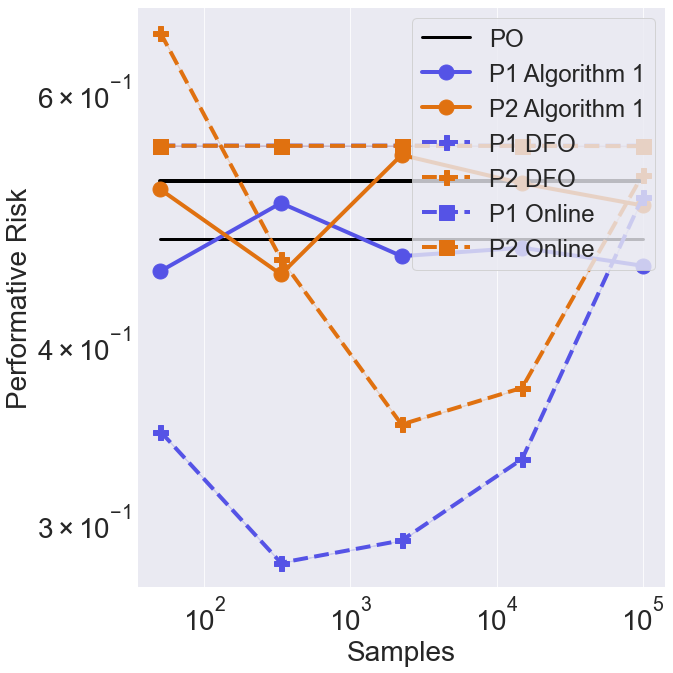

In [8]:
plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 4
plt.figure(figsize=(10,10))
# plt.subplot(2,1,1)
# plt.semilogx(num_rounds_lst, [PO_1 for i in num_rounds_lst],
#              '-', color='k', label='P1 Performative Optimum')
# plt.semilogx(num_rounds_lst, [PO_2 for i in num_rounds_lst],
#              '-', color='k', label='P2 Performative Optimum') 

# plt.semilogx(num_rounds_lst, p1_risks,
#              '--', color='#5553E6', label='P1 Solo Performative Risk')
# plt.semilogx(num_rounds_lst, p2_risks,
#              '--', color='#E07110', label='P2 2S Performative Risk')

# plt.semilogx(num_rounds_lst, p3_risks,
#              '-', color='#5553E6', label='P1 2S Performative Risk')
# plt.semilogx(num_rounds_lst, p4_risks,
#              '-', color='#E07110', label='P2 2S Performative Risk')
# plt.ylabel(r"$PR(\theta)$")
# plt.legend(fontsize=14)

# plt.subplot(2,1,2)
plt.loglog(num_rounds_lst, [PO_1 for i in num_rounds_lst],
           '-', color='k', label='PO', lw=3)
plt.loglog(num_rounds_lst, [PO_2 for i in num_rounds_lst],
           '-', color='k', lw=4)

# plt.loglog(num_rounds_lst, p1_risks,
#            '--', color='#5553E6', label='P1 Solo Performative Risk')
# plt.loglog(num_rounds_lst, p2_risks,
#            '--', color='#E07110', label='P2 2S Performative Risk')

plt.loglog(num_rounds_lst, np.nanmean(p3_risks,axis=0),
           '-', color='#5553E6', label='P1 Algorithm 1', lw=4, marker='o',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p3_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p3_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p4_risks,axis=0),
           '-', color='#E07110', label='P2 Algorithm 1', lw=4, marker='o',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p4_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p4_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#E07110')

plt.loglog(num_rounds_lst, np.nanmean(p1_risks,axis=0),
           '--', color='#5553E6', label='P1 DFO', lw=4, marker='P',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p1_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p1_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p2_risks,axis=0),
           '--', color='#E07110', label='P2 DFO', lw=4, marker='P',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p2_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p2_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#E07110')

plt.loglog(num_rounds_lst, np.nanmean(p5_risks,axis=0),
           '--', color='#5553E6', label='P1 Online', lw=4, marker='s',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p5_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p5_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p6_risks,axis=0),
           '--', color='#E07110', label='P2 Online', lw=4, marker='s',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p6_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p6_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#E07110')

plt.ylabel("Performative Risk")
plt.xlabel("Samples")
plt.legend(loc='upper right',fontsize=24)
# plt.ylim(0.09,1.3)
plt.tight_layout()
plt.savefig('../figures/dfo_vs_2stage_convergence.pdf', format='pdf')
plt.show()

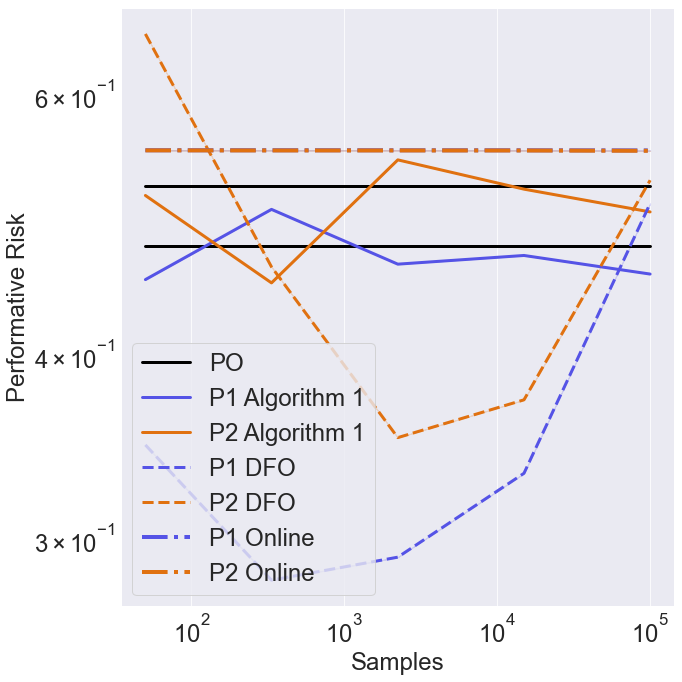

In [9]:
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 3
plt.figure(figsize=(10,10))

plt.loglog(num_rounds_lst, [PO_1 for i in num_rounds_lst],
           '-', color='k', label='PO', lw=3)
plt.loglog(num_rounds_lst, [PO_2 for i in num_rounds_lst],
           '-', color='k', lw=3)

plt.loglog(num_rounds_lst, np.nanmean(p3_risks,axis=0),
           '-', color='#5553E6', label='P1 Algorithm 1', lw=3)
plt.fill_between(num_rounds_lst, np.nanmean(p3_risks,axis=0)-2*np.sqrt(np.nanvar(p3_risks,axis=0)),
                 np.nanmean(p3_risks,axis=0)+2*np.sqrt(np.nanvar(p3_risks,axis=0)),
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p4_risks,axis=0),
           '-', color='#E07110', label='P2 Algorithm 1', lw=3)
plt.fill_between(num_rounds_lst, np.nanmean(p4_risks,axis=0)-2*np.sqrt(np.nanvar(p4_risks,axis=0)),
                 np.nanmean(p4_risks,axis=0)+2*np.sqrt(np.nanvar(p4_risks,axis=0)),
                 alpha=0.2, color='#E07110')

plt.loglog(num_rounds_lst, np.nanmean(p1_risks,axis=0),
           '--', color='#5553E6', label='P1 DFO', lw=3)
plt.fill_between(num_rounds_lst, np.nanmean(p1_risks,axis=0)-2*np.sqrt(np.nanvar(p1_risks,axis=0)),
                 np.nanmean(p1_risks,axis=0)+2*np.sqrt(np.nanvar(p1_risks,axis=0)),
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p2_risks,axis=0),
           '--', color='#E07110', label='P2 DFO', lw=3)
plt.fill_between(num_rounds_lst, np.nanmean(p2_risks,axis=0)-2*np.sqrt(np.nanvar(p2_risks,axis=0)),
                 np.nanmean(p2_risks,axis=0)+2*np.sqrt(np.nanvar(p2_risks,axis=0)),
                 alpha=0.2, color='#E07110')

plt.loglog(num_rounds_lst, np.nanmean(p5_risks,axis=0),
           '-.', color='#5553E6', label='P1 Online', lw=4)
plt.fill_between(num_rounds_lst, np.sort(p5_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p5_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p6_risks,axis=0),
           '-.', color='#E07110', label='P2 Online', lw=4)
plt.fill_between(num_rounds_lst, np.sort(p6_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p6_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#E07110')

plt.ylabel("Performative Risk")
plt.xlabel("Samples")
plt.legend(loc='best',fontsize=24)
plt.savefig('../figures/dfo_vs_2stage_convergence_var.pdf', format='pdf')
plt.tight_layout()
plt.show()

In [10]:
np.mean(np.linalg.norm(theta_final_p5-theta_PO_1,axis=2),axis=0)

array([0.65126999, 0.65127574, 0.65124494, 0.65121766, 0.65110797])